In [91]:
import requests
import pandas as pd
import seaborn as sns
import chardet

import numpy as np
# file from here
# https://github.com/CenterForOpenScience/rpp/blob/master/data_allformats/RPPdataConverted.csv
# downloaded 2024-03-23
with open('RPPdataConverted.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# It has weird encoding so 
# use chardet to find encoding
# and read in w/o errors
encoding = result['encoding'] 
print("Encoding", encoding)
df = pd.read_csv('RPPdataConverted.csv', encoding=encoding, on_bad_lines='skip')

Encoding Windows-1252


# Read in data

In [4]:
print(sorted(df.columns))

['1st.author.O', '1st.author.R', '80.power', '90.power', '95.power', 'Actual.Power.O', 'Analysis.completion.date.R', 'Area.of.expertise.R', 'Authors.O', 'Calculated.P.value.O', 'Citation.Count.1st.author.O', 'Citation.count.1st.author.R', 'Citation.count.paper.O', 'Citation.count.senior.author.O', 'Citation.count.senior.author.R', 'Citations.R', 'Coder.s.email.R', 'Collect.materials.from.authors', 'Completion.R', 'Contact.Researcher.R', 'Current.position.R', 'Data.collection.quality.R', 'Degree.R', 'Description.of.effect.O', 'Descriptors.O', 'Differences.R', 'Difficulty.of.implimentation.R', 'Direction.R', 'Discipline.O', 'Domain.expertise.R', 'Dummy', 'Effect.Size.R', 'Effect.similarity.R', 'Effect.size.O', 'Exciting.result.O', 'Feasibility.O', 'Findings.similarity.R', 'Implementation.quality.R', 'Institution.1st.author.O', 'Institution.1st.author.R', 'Institution.prestige.1st.author.O', 'Institution.prestige.1st.author.R', 'Institution.prestige.senior.author.O', 'Institution.prestige

# Data Wrangling

## Dates

In [59]:
df['rep_date'] = pd.to_datetime(df['Analysis.completion.date.R'], format='mixed')
df['orig_date'] = pd.to_datetime(df['Study.claim.date.R'], format='mixed')
df['time_since'] = (df['rep_date'] - df['orig_date']).dt.days

In [60]:
df[['rep_date', 'orig_date', 'time_since']].head(5)

,rep_date,orig_date,time_since
0,2015-01-07,2014-07-25,166.0
1,2014-11-18,2013-12-01,352.0
2,2015-05-21,2014-08-02,292.0
3,2015-01-01,2014-07-11,174.0
4,2015-01-08,2012-06-22,930.0


In [71]:
 df['Effect.Size.R']

0          __p^2 = .02
1         __p^2 = .051
2         __p^2 = .046
3      __p^2 = 0.00003
4         n_p^2 = 0.02
            ...       
157                NaN
158            w = .19
159                NaN
160       __p^2 = .065
161                NaN
Name: Effect.Size.R, Length: 162, dtype: object

## Effects

A few values are not reported in standardized effect sizes, but we coerce r=.-11 to an effect size of -0.11

In [88]:
def get_ef_size(x):
    if pd.isnull(x):
        return None
    else:
        try:
            size = float(x.split("=")[-1].strip())
            return size
        except Exception as e:
            print(e)
            return None
        
df['r_efsize'] = df['Effect.Size.R'].apply(get_ef_size)
df['o_efsize'] = df['Effect.size.O'].apply(get_ef_size)
df['diff'] = df['r_efsize'] - df['o_efsize']
df = df.query("o_efsize<=1&r_efsize<=1")
df2 = df.dropna(subset=['o_efsize', 'r_efsize', 'time_since'])

could not convert string to float: 'Av. proportion 0.77'
could not convert string to float: '.-11'


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_98237/3353311182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r_efsize'] = df['Effect.Size.R'].apply(get_ef_size)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_98237/3353311182.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['o_efsize'] = df['Effect.size.O'].apply(get_ef_size)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_98237/3353311182.py:14: SettingWithCopyWarning: 
A value is trying to be set on a c

<Axes: xlabel='diff', ylabel='time_since'>

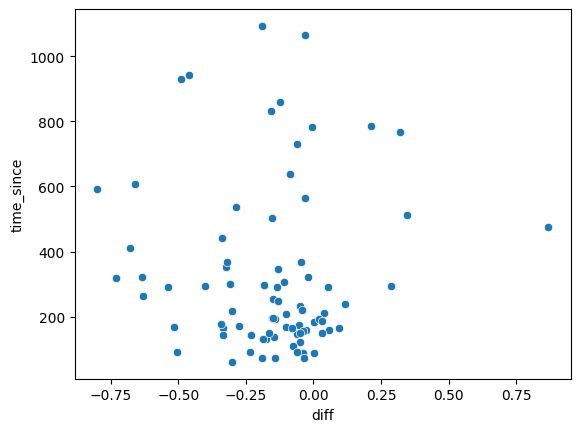

In [89]:
sns.scatterplot(data=df2, y='time_since', x='diff')

In [93]:
df['T_r']

KeyError: 'T_r'

In [94]:
df['T.r.O']

0      0.594605
1      0.611120
2      0.424980
3      0.228740
4      0.461301
         ...   
157    0.683979
158    0.283788
159         NaN
160    0.595272
161         NaN
Name: T.r.O, Length: 162, dtype: float64

In [95]:
df['T.r.R']

0      0.148340
1      0.229605
2     -0.215244
3     -0.006108
4      0.134812
         ...   
157         NaN
158   -0.175455
159         NaN
160    0.254142
161         NaN
Name: T.r.R, Length: 162, dtype: float64